In [41]:
import pandas as pd
import pandas
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.model_selection import train_test_split
import scipy
import scipy.fftpack

In [42]:
#load Insulin and CGM Data
insulinDf = pandas.read_csv('/content/drive/My Drive/InsulinData.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]
cgmDf = pandas.read_csv('/content/drive/My Drive/CGMData.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]

insulinDf2 = pandas.read_csv('/content/drive/My Drive/InsulinAndMealIntake670GPatient3.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]
cgmDf2 = pandas.read_csv('/content/drive/My Drive/CGMData670GPatient3.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]

cgmDf

,Date_Time,Index,New Device Time,BG Reading (mg/dL),Linked BG Meter ID,Basal Rate (U/h),Temp Basal Amount,Temp Basal Type,Temp Basal Duration (h:mm:ss),Bolus Type,Bolus Volume Selected (U),Bolus Volume Delivered (U),Bolus Duration (h:mm:ss),Prime Type,Prime Volume Delivered (U),Alarm,Suspend,Rewind,BWZ Estimate (U),BWZ Target High BG (mg/dL),BWZ Target Low BG (mg/dL),BWZ Carb Ratio (g/U),BWZ Insulin Sensitivity (mg/dL/U),BWZ Carb Input (grams),BWZ BG Input (mg/dL),BWZ Correction Estimate (U),BWZ Food Estimate (U),BWZ Active Insulin (U),Sensor Calibration BG (mg/dL),Sensor Glucose (mg/dL),ISIG Value,Event Marker,Bolus Number,Bolus Cancellation Reason,BWZ Unabsorbed Insulin Total (U),Final Bolus Estimate,Scroll Step Size,Insulin Action Curve Time,Sensor Calibration Rejected Reason,Preset Bolus,Bolus Source,Network Device Associated Reason,Network Device Disassociated Reason,Network Device Disconnected Reason,Sensor Exception,Preset Temp Basal Name
55342,2017-07-25 12:08:54,52859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,314.0,43.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55341,2017-07-25 12:13:54,52858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.0,45.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55340,2017-07-25 12:18:54,52857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309.0,44.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55339,2017-07-25 12:23:54,52856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311.0,44.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55338,2017-07-25 12:28:54,52855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311.0,44.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2018-02-12 13:02:27,20359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SENSOR_ERROR,NaN
3,2018-02-12 13:07:27,20358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SENSOR_ERROR,NaN
2,2018-02-12 13:12:27,20357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SENSOR_ERROR,NaN
1,2018-02-12 13:17:27,20356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.0,16.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
#filter NaNs and Zeros
insulinDFColY = insulinDf[insulinDf['BWZ Carb Input (grams)'].notnull() & insulinDf['BWZ Carb Input (grams)'] != 0]
insulinMealDates = pandas.DataFrame(insulinDFColY['Date_Time'])
insulinMealDates

insulinDFColY2 = insulinDf2[insulinDf2['BWZ Carb Input (grams)'].notnull() & insulinDf2['BWZ Carb Input (grams)'] != 0]
insulinMealDates2 = pandas.DataFrame(insulinDFColY2['Date_Time'])
insulinMealDates2

,Date_Time
23148,2017-05-09 13:14:52
23118,2017-05-09 19:32:06
23114,2017-05-09 19:32:23
23076,2017-06-09 08:48:28
23056,2017-06-09 13:22:26
...,...
435,2018-05-03 11:52:19
381,2018-05-03 17:19:29
230,2018-06-03 10:22:37
215,2018-06-03 12:40:57


In [44]:
#mealStartDates from Insulin CSV
insulinMealDates['Diff'] = insulinMealDates.iloc[:,0].diff(-1).dt.total_seconds().div(3600)
insulinMealDates = insulinMealDates.loc[insulinMealDates['Diff'] <= -2]
insulinNoMealDates = insulinMealDates.loc[insulinMealDates['Diff'] <= -4]
insulinMealDates.drop(insulinMealDates.head(1).index,inplace=True)
insulinMealDates.drop(insulinMealDates.tail(2).index,inplace=True)
insulinNoMealDates.drop(insulinNoMealDates.head(1).index,inplace=True)
insulinNoMealDates.drop(insulinNoMealDates.tail(2).index,inplace=True)
insulinNoMealDates

insulinMealDates2['Diff'] = insulinMealDates2.iloc[:,0].diff(-1).dt.total_seconds().div(3600)
insulinMealDates2 = insulinMealDates2.loc[insulinMealDates2['Diff'] <= -2]
insulinNoMealDates2 = insulinMealDates2.loc[insulinMealDates2['Diff'] <= -4]
insulinMealDates2.drop(insulinMealDates2.head(1).index,inplace=True)
insulinMealDates2.drop(insulinMealDates2.tail(2).index,inplace=True)
insulinNoMealDates2.drop(insulinNoMealDates2.head(1).index,inplace=True)
insulinNoMealDates2.drop(insulinNoMealDates2.tail(2).index,inplace=True)
insulinNoMealDates2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Date_Time,Diff
23114,2017-05-09 19:32:23,-733.268056
23076,2017-06-09 08:48:28,-4.566111
23056,2017-06-09 13:22:26,-6.081944
23038,2017-06-09 19:27:21,-708.179444
23014,2017-07-09 07:38:07,-5.264722
...,...,...
552,2018-03-03 20:45:06,-732.037222
536,2018-04-03 08:47:20,-4.086111
528,2018-04-03 12:52:30,-5.757500
510,2018-04-03 18:38:57,-712.006944


In [45]:
mealDatesList = []
for ind in insulinMealDates.index: 
#     print("InsulinMealData : " + str(insulinMealDates['Date_Time'][ind]))
    mealDatesList.append((cgmDf.loc[cgmDf['Date_Time'] >= insulinMealDates['Date_Time'][ind]])['Date_Time'].iloc[0])
mealDatesList

noMealDatesList = []
for ind in insulinNoMealDates.index: 
#     print("InsulinMealData : " + str(insulinMealDates['Date_Time'][ind]))
    noMealDatesList.append((cgmDf.loc[cgmDf['Date_Time'] >= insulinNoMealDates['Date_Time'][ind]])['Date_Time'].iloc[0])
noMealDatesList


mealDatesList2 = []
for ind in insulinMealDates2.index: 
#     print("InsulinMealData : " + str(insulinMealDates['Date_Time'][ind]))
    mealDatesList2.append((cgmDf2.loc[cgmDf2['Date_Time'] >= insulinMealDates2['Date_Time'][ind]])['Date_Time'].iloc[0])
mealDatesList2

noMealDatesList2 = []
for ind in insulinNoMealDates2.index: 
#     print("InsulinMealData : " + str(insulinMealDates['Date_Time'][ind]))
    noMealDatesList2.append((cgmDf2.loc[cgmDf2['Date_Time'] >= insulinNoMealDates2['Date_Time'][ind]])['Date_Time'].iloc[0])
noMealDatesList2


[Timestamp('2017-05-09 19:36:23'),
 Timestamp('2017-06-09 08:51:26'),
 Timestamp('2017-06-09 13:26:28'),
 Timestamp('2017-06-09 19:31:29'),
 Timestamp('2017-07-09 07:41:32'),
 Timestamp('2017-07-09 12:56:33'),
 Timestamp('2017-07-09 19:51:35'),
 Timestamp('2017-08-09 08:21:38'),
 Timestamp('2017-08-09 13:21:39'),
 Timestamp('2017-08-09 20:31:41'),
 Timestamp('2017-09-09 07:11:43'),
 Timestamp('2017-09-09 13:06:45'),
 Timestamp('2017-09-09 19:01:46'),
 Timestamp('2017-10-09 15:41:51'),
 Timestamp('2017-10-09 19:51:53'),
 Timestamp('2017-11-09 08:06:55'),
 Timestamp('2017-11-09 12:16:57'),
 Timestamp('2017-11-09 19:46:58'),
 Timestamp('2017-12-09 07:37:01'),
 Timestamp('2017-12-09 13:03:50'),
 Timestamp('2017-10-09 00:01:48'),
 Timestamp('2017-10-09 00:01:48'),
 Timestamp('2017-10-09 00:01:48'),
 Timestamp('2017-10-09 00:01:48'),
 Timestamp('2017-10-09 00:01:48'),
 Timestamp('2017-10-09 00:01:48'),
 Timestamp('2017-10-09 00:01:48'),
 Timestamp('2017-10-09 00:01:48'),
 Timestamp('2017-10-

In [46]:
mealDataMatrix = []
for mealDateTime in mealDatesList:
    idx = cgmDf[cgmDf['Date_Time'] == mealDateTime]['Sensor Glucose (mg/dL)'].index[0]
    mealDataMatrix.append(list(cgmDf['Sensor Glucose (mg/dL)'].iloc[cgmDf.shape[0]-1-idx-6:cgmDf.shape[0]-1-idx+24].values))
mealDataMatrix

noMealDataMatrix = []
for noMealDateTime in noMealDatesList:
    idx = cgmDf[cgmDf['Date_Time'] == noMealDateTime]['Sensor Glucose (mg/dL)'].index[0]
    noMealDataMatrix.append(list(cgmDf['Sensor Glucose (mg/dL)'].iloc[cgmDf.shape[0]-1-idx+24:cgmDf.shape[0]-1-idx+48].values))

# idx = cgmDf['Date_Time'].loc[lambda x: x=='2017-07-28 21:39:14'].index
# idx
# (cgmDf.iloc[idx[0] - 24 : idx[0] + 6])['Sensor Glucose (mg/dL)']

mealDf = pandas.DataFrame(mealDataMatrix).dropna()
mealDfAvg = mealDf.mean(axis=0)
mealDfAvg


noMealDf = pandas.DataFrame(noMealDataMatrix).dropna()
print(noMealDf.shape[0])
noMealDfAvg = noMealDf.mean(axis=0)
noMealDfAvg



mealDataMatrix2 = []
for mealDateTime2 in mealDatesList2:
    idx = cgmDf2[cgmDf2['Date_Time'] == mealDateTime2]['Sensor Glucose (mg/dL)'].index[0]
    mealDataMatrix2.append(list(cgmDf2['Sensor Glucose (mg/dL)'].iloc[cgmDf2.shape[0]-1-idx-6:cgmDf2.shape[0]-1-idx+24].values))
mealDataMatrix2

noMealDataMatrix2 = []
for noMealDateTime2 in noMealDatesList2:
    idx = cgmDf2[cgmDf2['Date_Time'] == noMealDateTime2]['Sensor Glucose (mg/dL)'].index[0]
    noMealDataMatrix2.append(list(cgmDf2['Sensor Glucose (mg/dL)'].iloc[cgmDf2.shape[0]-1-idx+24:cgmDf2.shape[0]-1-idx+48].values))

# idx = cgmDf['Date_Time'].loc[lambda x: x=='2017-07-28 21:39:14'].index
# idx
# (cgmDf.iloc[idx[0] - 24 : idx[0] + 6])['Sensor Glucose (mg/dL)']

mealDf2 = pandas.DataFrame(mealDataMatrix2).dropna()
mealDfAvg2 = mealDf2.mean(axis=0)
mealDfAvg2

noMealDf2 = pandas.DataFrame(noMealDataMatrix2).dropna()
print(noMealDf2.shape[0])
noMealDfAvg2 = noMealDf2.mean(axis=0)
noMealDfAvg2


339
269


0     193.026022
1     191.368030
2     189.706320
3     188.349442
4     187.289963
5     186.100372
6     184.234201
7     182.605948
8     181.345725
9     181.174721
10    181.368030
11    180.620818
12    180.553903
13    182.676580
14    184.260223
15    184.159851
16    182.721190
17    180.776952
18    178.687732
19    175.732342
20    174.379182
21    172.342007
22    171.260223
23    170.297398
dtype: float64

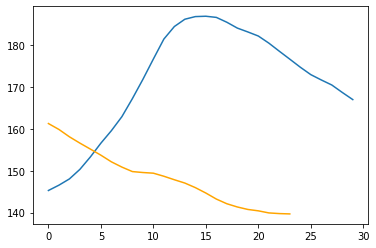

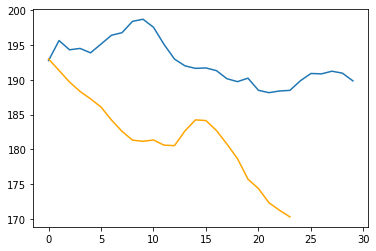

In [47]:
plt.plot(mealDfAvg)
plt.plot(noMealDfAvg,color='orange')
plt.show()

plt.plot(mealDfAvg2)
plt.plot(noMealDfAvg2,color='orange')
plt.show()


        0      1      2      3      4   ...     25     26     27     28     29
0    304.0  292.0  281.0  268.0  259.0  ...  267.0  274.0  284.0  283.0  278.0
1     40.0   40.0   40.0   40.0   60.0  ...   70.0   67.0   74.0   77.0   81.0
2    212.0  210.0  204.0  200.0  199.0  ...  210.0  210.0  209.0  210.0  209.0
3    145.0  141.0  137.0  133.0  129.0  ...  177.0  173.0  165.0  153.0  152.0
4     40.0   40.0   46.0   53.0   57.0  ...  175.0  183.0  191.0  198.0  200.0
..     ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
719  162.0  160.0  159.0  158.0  159.0  ...  122.0  124.0  131.0  134.0  135.0
720  162.0  160.0  159.0  158.0  159.0  ...  122.0  124.0  131.0  134.0  135.0
721  162.0  160.0  159.0  158.0  159.0  ...  122.0  124.0  131.0  134.0  135.0
722  264.0  261.0  257.0  253.0  247.0  ...   94.0   90.0   85.0   88.0   90.0
723  264.0  261.0  257.0  253.0  247.0  ...   94.0   90.0   85.0   88.0   90.0

[724 rows x 30 columns]
        0      1      2    

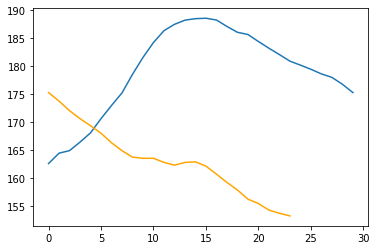

In [48]:
meal = pandas.concat([mealDf, mealDf2], ignore_index=True, sort = False)
mealDataMatrix = meal.values.tolist()
no_meal = pandas.concat([noMealDf, noMealDf2], ignore_index=True, sort = False)
noMealDataMatrix = no_meal.values.tolist()
print(meal)
print(no_meal)

mealDfAvg = meal.mean(axis=0)
mealDfAvg


noMealDfAvg = no_meal.mean(axis=0)
noMealDfAvg

plt.plot(mealDfAvg)
plt.plot(noMealDfAvg,color='orange')
plt.show()

In [49]:
def extract_cgm_velocity(df, result_df):
  velocityDF = pd.DataFrame()
  for i in range(0,df.shape[1]-5):
      velocityDF['Vel_'+str(i)] = (df.iloc[:,i+5]-df.iloc[:,i])
  result_df['Window_Velocity_Max']=velocityDF.max(axis = 1, skipna=True)

In [50]:
def extract_cgm_trend(df, result_df):
    lunch = [[]]
    means = []
    for i in range(1, len(df)):
        lunch.append(df.iloc[i])
    for i in range(0, len(lunch)):
        means.append(df.iloc[i].mean())
    countmaster = []
    for i in range(0, len(lunch)):
        count = 0
        for j in df.iloc[i]:
            if j < means[i]:    
                count += 1
        countmaster.append(count)
    percentage=[]
    for i in countmaster:
        percentage.append((i / len(df.iloc[0])) * 100)
    result_df['cgmTrend'] = np.asarray(percentage)

In [51]:
#Extract Accelaration
def extract_acceleration(df, result_df):
    d=[]
    q=[]
    f=[]
    acc = [[],[],[],[]]
    for j in range(0, df.shape[0]):
        b = df.iloc[j]
        d = []
        for i in range(len(b)):
            if(np.isnan(b[i])):
                continue
            else:
                d.append(b[i])

        if(len(d) >= 1):
            solar_elevation_angle_1stdev = np.gradient(d)
            solar_elevation_angle_2nddev = np.gradient(solar_elevation_angle_1stdev)

            q = solar_elevation_angle_2nddev
            arr = q[5:10]
            acc[0].append(np.mean(arr))
            arr = q[10:15]
            acc[1].append(np.mean(arr))
            arr = q[15:20]
            acc[2].append(np.mean(arr))
            arr = q[20:25]
            acc[3].append(np.mean(arr))

        else:
            for i in range(4):
              acc[i].append(0)
    for i in range(4):
      result_df['acc'+str(i+1)] = acc[i]

In [52]:
#Extract entropy
def get_entropy(series):
    series_counts = series.value_counts()
    entropy = scipy.stats.entropy(series_counts)  
    return entropy

def extract_entropy(df, result_df):
    result_df['Entropy'] = df.apply(lambda row: get_entropy(row), axis=1) 


In [53]:
#Extract PolyFit
def extract_polyfit(df, result_df):
   
    colid = []
    no_of_rows = df.shape[0]
    no_of_cols = df.shape[1]

    result = df.T
    no_of_coefficients = 6
    cols = []
    for i in range(0, no_of_rows) :
        cols.append(str(i))
    result.columns = cols
    
    for i in range(0, no_of_cols) :
        colid.append(i + 1)
    x = np.array(colid)
    fftmatrix = []
    
    for i in range(0, no_of_rows) :
        y = np.array(result[str(i)])
        polyres = np.polyfit(x, y, no_of_coefficients-1)  
        fftmatrix.append(polyres.tolist())
    fftmatrix = np.array(fftmatrix)   
  
    for i in range(no_of_coefficients) :
        result_df['Coefficient'+str(i)] = fftmatrix[:, i]
    #return result_df
    result_df.head()


In [54]:
#Extract Windowed mean
def extract_windowed_mean(df, result_df):
  if(df.shape[1] > 24):
    for i in range(6,df.shape[1],6):
      result_df['Mean_'+str(i-6)] = df.iloc[:,i:i+6].mean(axis = 1)
  else:
    for i in range(0,df.shape[1],6):
      result_df['Mean_'+str(i)] = df.iloc[:,i:i+6].mean(axis = 1)

In [55]:
# FFT- Finding top 8 values for each row
import pywt
from numpy.fft import fft
def get_fft(row):
    cgmFFTValues = np.abs(fft(row))
    cgmFFTValues.sort()
    return np.flip(cgmFFTValues)[0:8]

def extract_fft(df, result_df):
  FFT = pd.DataFrame()
  FFT['FFT_Top2'] = df.apply(lambda row: get_fft(row), axis=1)
  FFT_updated = pd.DataFrame(FFT.FFT_Top2.tolist(), columns=['FFT_1', 'FFT_2', 'FFT_3', 'FFT_4', 'FFT_5', 'FFT_6', 'FFT_7', 'FFT_8'])
  FFT_updated.head()
  for i in range(8):
    result_df['FFT_'+str(i+1)] = FFT_updated['FFT_'+str(i+1)]

In [56]:
#1. Feature extraction
meal_features = pd.DataFrame()
no_meal_features = pd.DataFrame()

def extract_features(data, result_df) : 
    extract_cgm_velocity(data, result_df)
    extract_windowed_mean(data, result_df)
    extract_cgm_trend(data, result_df)
    extract_fft(data, result_df)
    extract_acceleration(data, result_df)
    extract_entropy(data, result_df)
    # extract_polyfit(data, result_df)

extract_features(meal, meal_features)
#print(meal_features)
extract_features(no_meal, no_meal_features)
#print(no_meal_features)

no_meal_features
# 


,Window_Velocity_Max,Mean_0,Mean_6,Mean_12,Mean_18,cgmTrend,FFT_1,FFT_2,FFT_3,FFT_4,FFT_5,FFT_6,FFT_7,FFT_8,acc1,acc2,acc3,acc4,Entropy
0,-2.0,166.000000,115.166667,78.833333,63.500000,54.166667,2541.0,557.106264,557.106264,266.208115,266.208115,190.978136,190.978136,134.614264,1.00,0.30,1.05,-0.3125,3.120292
1,-29.0,252.000000,186.666667,111.166667,50.500000,50.000000,3602.0,1092.090082,1092.090082,490.517942,490.517942,316.941740,316.941740,240.538978,-0.80,0.75,0.50,2.3125,3.120292
2,39.0,100.500000,97.666667,120.000000,134.000000,58.333333,2713.0,247.070293,247.070293,88.154528,88.154528,81.835200,81.835200,34.828150,0.70,2.05,-2.35,0.1250,2.535025
3,2.0,134.833333,96.666667,88.666667,47.333333,41.666667,2205.0,346.151763,346.151763,315.605608,315.605608,155.849204,155.849204,103.320428,1.35,-0.85,-1.20,2.2500,2.867440
4,60.0,197.833333,245.166667,263.833333,248.333333,41.666667,5731.0,419.394090,419.394090,130.679203,130.679203,44.553339,44.553339,28.816011,0.45,-2.75,-0.60,0.8750,3.004767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,5.0,182.666667,169.666667,169.166667,170.166667,66.666667,4150.0,83.618468,83.618468,54.079591,54.079591,22.435357,22.435357,18.910335,0.30,0.40,-0.35,0.0625,2.301092
604,26.0,134.000000,138.500000,160.500000,171.500000,58.333333,3627.0,253.543508,253.543508,64.217725,64.217725,53.842363,53.842363,47.441797,0.50,0.85,-1.25,-0.7500,2.578629
605,26.0,134.000000,138.500000,160.500000,171.500000,58.333333,3627.0,253.543508,253.543508,64.217725,64.217725,53.842363,53.842363,47.441797,0.50,0.85,-1.25,-0.7500,2.578629
606,26.0,134.000000,138.500000,160.500000,171.500000,58.333333,3627.0,253.543508,253.543508,64.217725,64.217725,53.842363,53.842363,47.441797,0.50,0.85,-1.25,-0.7500,2.578629


In [57]:
from sklearn.decomposition import PCA

# # PCA
pca = PCA(n_components=10)
#Fit meal features
principalComponents = pca.fit(meal_features)
#Transform meal features
PCA_mealdata = pca.fit_transform(meal_features)

#Fit no-meal features
principalComponents = pca.fit(no_meal_features)
#Tranform no-meal features
PCA_nomealdata = pca.fit_transform(no_meal_features)

#Create feature matrix
Training_data = np.concatenate((PCA_mealdata, PCA_nomealdata), axis=0)

Training_labels = []
no_of_mealrows = meal.shape[0]
no_of_nomealrows = no_meal.shape[0]
for i in range(no_of_mealrows) :
    Training_labels.append(1)
for i in range(no_of_nomealrows) :
    Training_labels.append(0)


In [58]:
#3. Training classifiers

from sklearn import tree
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import pickle


X = pd.DataFrame(Training_data)
y = pd.DataFrame(Training_labels)
Z = pd.concat([X, y], axis=1, sort=False)

#Randomize data
Total_Data = Z.reindex(np.random.permutation(Z.index))

#K fold cross validation
kf = RepeatedKFold(n_splits=5, n_repeats=5)

#Decision Tree
for train_index, test_index in kf.split(Total_Data):
    trainData = Total_Data.iloc[train_index, 0:10]
    trainLabel = Total_Data.iloc[train_index, 10]
    testData = Total_Data.iloc[test_index, 0:10]
    testLabel = Total_Data.iloc[test_index, 10]

    clf = tree.DecisionTreeClassifier()
    clf.fit(trainData, trainLabel)
    predictedLabel = clf.predict(testData)
    
    acc = int(accuracy_score(testLabel, predictedLabel)*100)
    
    print(classification_report(testLabel, predictedLabel))
    print(confusion_matrix(testLabel, predictedLabel))

    filename = str(acc)+"_decision_tree.pkl"
    pickle.dump(clf, open(filename, 'wb'))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       117
           1       0.94      0.87      0.90       150

    accuracy                           0.89       267
   macro avg       0.89      0.89      0.89       267
weighted avg       0.90      0.89      0.89       267

[[108   9]
 [ 20 130]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       124
           1       0.88      0.85      0.86       143

    accuracy                           0.85       267
   macro avg       0.85      0.85      0.85       267
weighted avg       0.85      0.85      0.85       267

[[107  17]
 [ 22 121]]
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       118
           1       0.86      0.82      0.84       148

    accuracy                           0.82       266
   macro avg       0.82      0.82      0.82       266
weighted avg       0.83     